In [1]:
# Common imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [2]:
# Import from utils
import sys
import importlib
sys.path.append('../')

import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\USUARIO\\Desktop\\Projects\\4Geeks_temporal_series\\src\\river\\..\\utils.py'>

In [3]:
df = pd.read_csv('../../data/processed/river_arno.csv')
df = df.sort_values(by=["Date"])
df

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Incisa,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,1998-01-01,0.0,0.0,0.4,0.0,0.0,0.0,0.0,26.25,1.82
1,1998-01-02,0.0,0.0,0.4,0.0,0.0,0.0,0.0,26.25,1.94
2,1998-01-03,0.0,0.0,0.4,0.0,0.0,0.0,0.0,26.25,2.11
3,1998-01-04,0.0,0.0,0.4,0.0,0.0,0.0,0.0,26.25,1.84
4,1998-01-05,0.0,0.0,0.4,0.0,0.0,0.0,0.0,26.25,1.88
...,...,...,...,...,...,...,...,...,...,...
8212,2020-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.10,1.34
8213,2020-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.10,1.21
8214,2020-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.10,1.30
8215,2020-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.10,1.19


# Modelado

In [4]:
utils.get_null_percentage_per_column(df)

Date                         0.0
Rainfall_Le_Croci            0.0
Rainfall_Cavallina           0.0
Rainfall_S_Agata             0.0
Rainfall_Mangona             0.0
Rainfall_S_Piero             0.0
Rainfall_Vernio              0.0
Rainfall_Incisa              0.0
Temperature_Firenze          0.0
Hydrometry_Nave_di_Rosano    0.0
dtype: float64

In [5]:
# Selección de variables
target_col = "Hydrometry_Nave_di_Rosano"
feature_cols = [col for col in df.columns if col not in ["Date", target_col]]

In [6]:
# Normalización
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Incisa,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,1998-01-01,-0.327442,-0.29446,-0.267721,-0.315485,-0.312558,-0.25386,-0.266415,0.920689,1.82
1,1998-01-02,-0.327442,-0.29446,-0.267721,-0.315485,-0.312558,-0.25386,-0.266415,0.920689,1.94
2,1998-01-03,-0.327442,-0.29446,-0.267721,-0.315485,-0.312558,-0.25386,-0.266415,0.920689,2.11
3,1998-01-04,-0.327442,-0.29446,-0.267721,-0.315485,-0.312558,-0.25386,-0.266415,0.920689,1.84
4,1998-01-05,-0.327442,-0.29446,-0.267721,-0.315485,-0.312558,-0.25386,-0.266415,0.920689,1.88
...,...,...,...,...,...,...,...,...,...,...
8212,2020-06-26,-0.327442,-0.29446,-0.332047,-0.315485,-0.312558,-0.25386,-0.266415,1.029650,1.34
8213,2020-06-27,-0.327442,-0.29446,-0.332047,-0.315485,-0.312558,-0.25386,-0.266415,1.029650,1.21
8214,2020-06-28,-0.327442,-0.29446,-0.332047,-0.315485,-0.312558,-0.25386,-0.266415,1.029650,1.30
8215,2020-06-29,-0.327442,-0.29446,-0.332047,-0.315485,-0.312558,-0.25386,-0.266415,1.029650,1.19


In [7]:
# Dividir datos en entrenamiento y prueba (80%-20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [8]:
# Preparar datos para LSTM
def create_sequences(data, target_col, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length][feature_cols].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train, target_col, seq_length)
X_test, y_test = create_sequences(test, target_col, seq_length)

In [9]:
# Construcción del modelo LSTM
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 50s 75ms/step - loss: 0.4093 - val_loss: 0.5060
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - loss: 0.2031 - val_loss: 0.3878
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - loss: 0.2266 - val_loss: 0.5150
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - loss: 0.2744 - val_loss: 0.5544
Epoch 5/50
 98/408 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - loss: 0.2876

# Evaluación del modelo

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MAE: 0.3659, RMSE: 0.6197


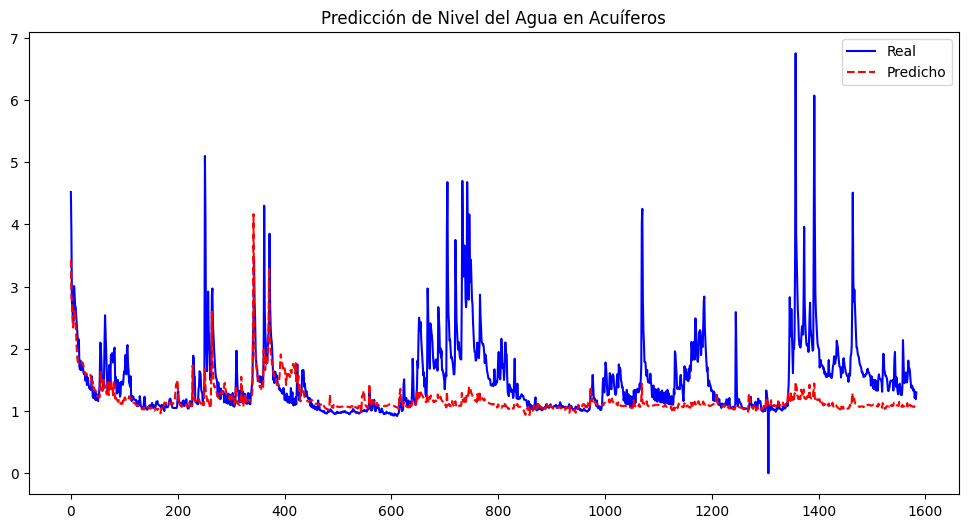

In [ ]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color="blue")
plt.plot(y_pred, label="Predicho", color="red", linestyle="dashed")
plt.legend()
plt.show()
